<h1 style="font-size:30px;">Semantic Segmentation using UNet (CamVid Dataset)</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import cv2
import glob as glob
import albumentations as A
import requests
import zipfile

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Input,
                                     Conv2DTranspose, 
                                     Dropout, concatenate, Activation)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

block_plot = False
plt.rcParams['image.cmap'] = 'gray'

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

##  System Configuration

In [2]:
def system_config(SEED_VALUE):

    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config(7)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU


## Training and Dataset Configurations


In [3]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 32
    IMG_WIDTH:   int = 256
    IMG_HEIGHT:  int = 256
    DATA_TRAIN_IMAGES: str = 'dataset_camvid_trainval/train/*.png'
    DATA_TRAIN_LABELS: str = 'dataset_camvid_trainval/train_labels/*.png'
    DATA_VALID_IMAGES: str = 'dataset_camvid_trainval/val/*.png'
    DATA_VALID_LABELS: str = 'dataset_camvid_trainval/val_labels/*.png'
        
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:      int = 8
    EPOCHS:          int = 201
    LEARNING_RATE: float = 0.0001
    CHECKPOINT_DIR:  str = 'model_checkpoint/UNet_CamVid'

@dataclass(frozen=True)
class InferenceConfig:
    NUM_BATCHES:     int = 3

## Modeling UNet

In [4]:
def unet(num_classes, shape):
    
    model_input = Input(shape=shape)
        
    # Encoder_block-1.
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(model_input)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Encoder_block-2.
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Encoder_block-3.
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Encoder_block-4.
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Intermedicate_block.
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder_blcok-1.
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2),padding = 'same')(c5)
    # Lateral connection from Encoder_block-4.
    u6 = concatenate([u6,c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding= 'same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu',  padding= 'same')(c6)

    # Decoder_block-2.
    u7 = Conv2DTranspose(256, (2,2), strides = (2, 2), padding= 'same')(c6)
    # Lateral connection from Encoder_block-3.
    u7 = concatenate([u7,c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding= 'same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu',  padding= 'same')(c7)

    # Decoder_block-3.
    u8 = Conv2DTranspose(128, (2,2), strides= (2, 2),padding = 'same')(c7)
    # Lateral connection from Encoder_blcok-2.
    u8 = concatenate([u8,c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding= 'same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu',   padding= 'same')(c8)

    # Decoder_blcok-4.
    u9 = Conv2DTranspose(64, (2, 2), strides = (2, 2), padding= 'same')(c8)
    # Lateral connection from Encoder_blcok-1.
    u9 = concatenate([u9,c1], axis =3)
    c9 = Conv2D(64, (3, 3), activation ='relu',  padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation ='relu',  padding='same')(c9)

    # 1x1 convolution to limit the depth of the feature maps to the number of classes.
    outputs = Conv2D(num_classes, (1, 1), use_bias=False)(c9)
    
    model_output = Activation('softmax')(outputs)
        
    model = Model(inputs=model_input, outputs=model_output)

    return model

In [5]:
model = unet(num_classes=DatasetConfig.NUM_CLASSES, 
             shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, 3))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

### 4.1 Download and Extract the Dataset

In [6]:
# To Download processed dataset.
def download_file(url, save_name):
    file = requests.get(url)
    open(save_name, 'wb').write(file.content)

In [7]:
# To Unzip the dataset file.
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [8]:
save_name = "dataset_camvid_trainval.zip"

if not os.path.exists(save_name):
    download_file(
        "https://www.dropbox.com/s/nkzsucbeblzq3dm/dataset_camvid_trainval.zip?dl=1",
        save_name
    )

    unzip(zip_file=save_name)

Extracted all


## Custom Data Loader Class
 

In [9]:
# Custom Class for creating training and validation (segmentation) dataset objects.
class CustomSegDataLoader(Sequence):
    
    def __init__(self, batch_size, image_size, image_paths, mask_paths, num_classes, aug):
        
        self.batch_size  = batch_size
        self.image_size  = image_size
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.num_classes = num_classes
        self.aug = aug
        
        self.x = np.empty((self.batch_size,) + self.image_size + (3,), dtype="float32")
        self.y = np.empty((self.batch_size,) + self.image_size, dtype="float32")
        
        if self.aug:
            self.train_transforms = self.transforms()
        
        self.resize_transforms = self.resize()
        
    def __len__(self):
        
        return len(self.mask_paths) // self.batch_size

    def transforms(self):
        
        # Data augmentation.
        train_transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, 
                               shift_limit=0.2, p=0.5, border_mode=0),
        ])
        return train_transforms
    
    def resize(self):
        
        resize_transforms = A.Resize(
            height=self.image_size[0], width=self.image_size[1],
            interpolation=cv2.INTER_NEAREST,
            always_apply=True, p=1
        )
        return resize_transforms
    
    def reset_array(self):
        self.x.fill(0.)
        self.y.fill(0.)

    def __getitem__(self, idx):
        self.reset_array()
        i = idx * self.batch_size
        batch_image_paths = self.image_paths[i : i + self.batch_size]
        batch_mask_paths = self.mask_paths[i : i + self.batch_size]
        
        for j, (input_image, input_mask) in enumerate(zip(batch_image_paths, batch_mask_paths)):

            # Read the image and convert to RGB.
            img = cv2.imread(input_image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
     
            # Read the mask and convert to RGB.
            msk = cv2.imread(input_mask)
            msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)

            # Resize the image and mask.
            resized  = self.resize_transforms(image=img, mask=msk)
            img, msk = resized['image'], resized['mask']
            
            if self.aug:
                # Apply augmentations.
                train_augment = self.train_transforms(image=img, mask=msk)
                img, msk = train_augment['image'], train_augment['mask']

            # Store image in x.
            self.x[j] = img / 255. # Normalizing image to be in range [0.0, 1.0]
            
            # Convert RGB segmentation mask to multi-channel (one-hot) encoded arrays where 
            # each channel represents a single class whose pixel values are either 0 or 1, 
            # where a 1 represents a pixel location associated with the class that corresponds 
            # to the channel.
            msk = rgb_to_onehot(msk)
            
            # Convert the multi-channel (one-hot encoded) mask to a single channel (grayscale)   
            # representation whose values contain the class IDs for each class (essentially 
            # collapsing the one-hot encoded arrays into a single channel).
            self.y[j] = msk.argmax(-1)
            
        return self.x, self.y

## Helper Functions and Utilities

In [10]:
# Dictionary mapping class IDs to colors from the original dataset ground truth masks.
id2color = {
    0: (64, 128, 64),
    1: (192, 0, 128),
    2: (0, 128, 192),
    3: (0, 128, 64),
    4: (128, 0, 0),
    5: (64, 0, 128),
    6: (64, 0, 192),
    7: (192, 128, 64),
    8: (192, 192, 128),
    9: (64, 64, 128),
    10: (128, 0, 192),
    11: (192, 0, 64),
    12: (128, 128, 64),
    13: (192, 0, 192),
    14: (128, 64, 64),
    15: (64, 192, 128),
    16: (64, 64, 0),
    17: (128, 64, 128),
    18: (128, 128, 192),
    19: (0, 0, 192),
    20: (192, 128, 128),
    21: (128, 128, 128),
    22: (64, 128, 192),
    23: (0, 0, 64),
    24: (0, 64, 64),
    25: (192, 64, 128),
    26: (128, 128, 0),
    27: (192, 128, 192),
    28: (64, 0, 64),
    29: (192, 192, 0),
    30: (0,0, 0),
    31: (64, 192, 0)
 }

In [11]:
# Function to one-hot encode RGB mask labels.
def rgb_to_onehot(rgb_arr, color_map=id2color, num_classes=DatasetConfig.NUM_CLASSES):
    
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros( shape, dtype=np.float32 )
    
    for i, classes in enumerate(color_map):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_map[i], axis=1).reshape(shape[:2])
        
    return arr

In [12]:
# Function to convert a single channel mask representation to an RGB mask.
def num_to_rgb(num_arr, color_map=id2color):
    
    single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))
    
    for k in color_map.keys():
        output[single_layer==k] = color_map[k]
        
    return np.float32(output) / 255. # return a floating point array in range [0.0, 1.0]

Helper function to overlay an RGB segmentation map on top of an RGB image.

In [13]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):
    
    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.
    
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return np.clip(image, 0.0, 1.0)

In [14]:
def display_image_and_mask(data_list, color_mask=False, color_map=id2color):
    
    plt.figure(figsize=(16, 6))
    title = ['GT Image', 'GT Mask', 'Overlayed Mask']

    grayscale_gt_mask = data_list[1]
    
    # Create RGB segmentation map from grayscale segmentation map.
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)
    
    # Create the overlayed image.
    overlayed_image = image_overlay(data_list[0], rgb_gt_mask)
    
    data_list.append(overlayed_image)
    
    for i in range(len(data_list)):
        plt.subplot(1, len(data_list), i+1)
        plt.title(title[i])
        if title[i] == 'GT Mask':
            if color_mask:
                plt.imshow(np.array(rgb_gt_mask))
            else:
                plt.imshow(np.array(grayscale_gt_mask))
        else:
            plt.imshow(np.array(data_list[i]))
        plt.axis('off')
        
    plt.show()

## Using the Custom Data Loader Class

In [15]:
def create_datasets(aug=False):
    
    # Training image and mask paths.
    train_images = sorted(glob.glob(f"{DatasetConfig.DATA_TRAIN_IMAGES}"))
    train_masks  = sorted(glob.glob(f"{DatasetConfig.DATA_TRAIN_LABELS}"))
    
    # Validation image and mask paths.
    valid_images = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_IMAGES}"))
    valid_masks  = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_LABELS}"))

    # Train data loader.
    train_ds = CustomSegDataLoader(batch_size=TrainingConfig.BATCH_SIZE,
                                   image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                   image_paths=train_images,
                                   mask_paths=train_masks,
                                   num_classes=DatasetConfig.NUM_CLASSES,
                                   aug=aug,
                                  )
    # Validation data loader.
    valid_ds = CustomSegDataLoader(batch_size=TrainingConfig.BATCH_SIZE,
                                   image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                   image_paths=valid_images,
                                   mask_paths=valid_masks,
                                   num_classes=DatasetConfig.NUM_CLASSES,
                                   aug=False,
                                  )
    
    return train_ds, valid_ds

In [16]:
train_ds, valid_ds = create_datasets(aug=True)

### Display Sample Training Images


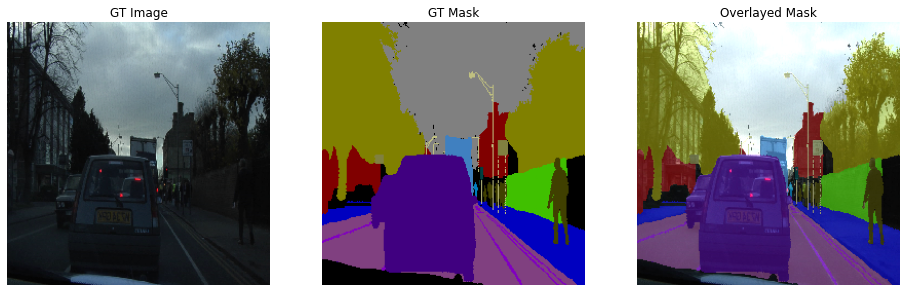

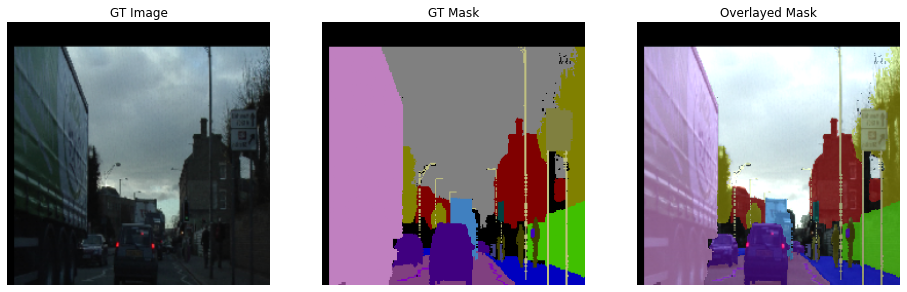

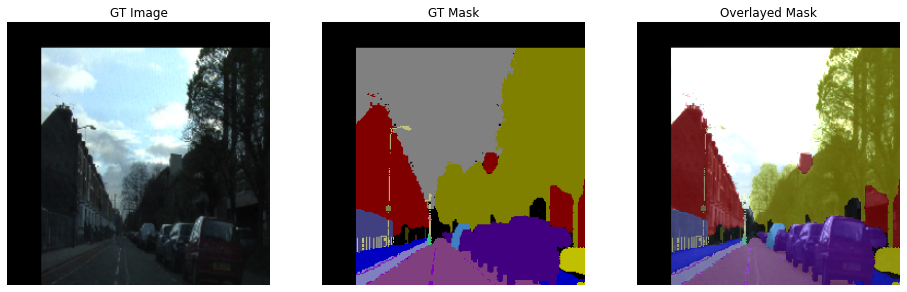

In [17]:
for i, (images, masks) in enumerate(train_ds):
    if i == 3:
        break
    image, mask = images[0], masks[0]
    display_image_and_mask([image, mask], color_mask=True)

## Custom Accuracy Metric and Loss Function

### Mean IoU Metric

In [18]:
def mean_iou(y_true, y_pred):
    """
    Arguments:
    y_true (ndarray or tensor): Ground truth mask (G). Shape: (batch_size, height, width)
                               Sparse representation of segmentation mask.

    y_pred (ndarray or tensor): Prediction (P) from the model with or without softmax.
                                Shape: (batch_size, height, width, num_classes).

    return (scalar): Classwise mean IoU Metric.
    """
    
    # Get total number of classes from model output.
    num_classes = y_pred.shape[-1]

    # Convert single channel (sparse) ground truth labels to one-hot encoding for metric computation.
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)

    # Convert multi-channel predicted output to one-hot encoded thresholded output for metric computation. 
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    # Axes corresponding to image width and height: [B, H, W, C].
    axes = (1, 2)

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=axes)

    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=axes) + tf.math.reduce_sum(y_pred, axis=axes)

    # Union: Shape: (batch_size, num_classes)
    union = total - intersection

    # Boolean (then converted to float) value for each class if it is present or not. 
    # Shape: (batch_size, num_classes)
    is_class_present =  tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)

    # Sum along axis(1) to get number of classes in each image.
    # Shape: (batch_size,)
    num_classes_present = tf.math.reduce_sum(is_class_present, axis=1)

    # Here, we use tf.math.divide_no_nan() to prevent division by 0 (i.e., 0/0 = 0).
    # Shape: (batch_size, num_classes)
    iou = tf.math.divide_no_nan(intersection, union)

    # IoU per image. Average over the total number of classes present in y_true and y_pred.
    # Shape: (batch_size,)
    iou = tf.math.reduce_sum(iou, axis=1) / num_classes_present
    
    # Compute the mean across the batch axis. Shape: Scalar
    mean_iou = tf.math.reduce_mean(iou)
    
    return mean_iou

### Dice / CCE Loss

In [19]:
def dice_coef_loss(y_true, y_pred):
    """
    Arguments:
    y_true (ndarray or tensor): Ground truth mask (G). Shape: (batch_size, height, width)
                                Sparse representation of segmentation mask.

    y_pred (ndarray or tensor): Softmax prediction (P) from the model.
                                Shape: (batch_size, height, width, num_classes).

    return (scalar): Loss
    """
    num_classes = y_pred.shape[-1]
    
    # Convert single channel ground truth labels to one-hot encoding for metric computation.
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)
    
    # Axes corresponding to image width and height: [B, H, W, C].
    axes = (1, 2)
    
    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=axes)
    
    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=axes) + tf.math.reduce_sum(y_pred, axis=axes)
    
    # Dice coefficient. Shape: (batch_size, num_classes)
    eps = 1e-3
    dc = (2. *  intersection + eps) / (total + eps)
    
    # Compute the mean over the remaining axes (batch and classes).
    dc_mean = tf.math.reduce_mean(dc)
    
    # Compute cross-entropy loss.
    CCE =  tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    
    return 1.0 - dc_mean + CCE

## Compile and Train the Model

### Adding Custom Metrics and Loss Functions



In [20]:
model.compile(optimizer=Adam(learning_rate=TrainingConfig.LEARNING_RATE), 
              loss=dice_coef_loss,
              metrics=['accuracy', mean_iou],
             )

### Adding Model Checkpoint Callback


In [ ]:
# Create a new checkpoint directory every time.
if not os.path.exists(TrainingConfig.CHECKPOINT_DIR):
    os.makedirs(TrainingConfig.CHECKPOINT_DIR)
    
num_versions = len(os.listdir(TrainingConfig.CHECKPOINT_DIR)) + 1
version_dir = TrainingConfig.CHECKPOINT_DIR +'/version_' + str(num_versions)
os.makedirs(version_dir)

# Callback to save the best model based on validation loss.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=version_dir,
                                                               save_weights_only=False,
                                                               monitor='val_mean_iou',
                                                               mode='max',
                                                               save_best_only=True,
                                                              )

### Train the Model

In [ ]:
history = model.fit(train_ds,
                    epochs=TrainingConfig.EPOCHS, 
                    verbose=1,
                    validation_data=valid_ds,
                    workers=4,
                    use_multiprocessing=True,
                    callbacks=[model_checkpoint_callback],
                   )

Epoch 1/201
46/46 [==============================] - 38s 400ms/step - loss: 6.2625 - accuracy: 0.1932 - mean_iou: 0.0177 - val_loss: 3.5595 - val_accuracy: 0.1986 - val_mean_iou: 0.0137
Epoch 2/201
46/46 [==============================] - 21s 430ms/step - loss: 3.5011 - accuracy: 0.3204 - mean_iou: 0.0319 - val_loss: 3.4063 - val_accuracy: 0.2239 - val_mean_iou: 0.0170
Epoch 3/201
46/46 [==============================] - 20s 429ms/step - loss: 3.1434 - accuracy: 0.3845 - mean_iou: 0.0425 - val_loss: 3.2514 - val_accuracy: 0.2835 - val_mean_iou: 0.0255
Epoch 4/201
46/46 [==============================] - 21s 433ms/step - loss: 3.0159 - accuracy: 0.4078 - mean_iou: 0.0483 - val_loss: 3.1987 - val_accuracy: 0.2768 - val_mean_iou: 0.0288
Epoch 5/201
46/46 [==============================] - 15s 308ms/step - loss: 2.9303 - accuracy: 0.4209 - mean_iou: 0.0549 - val_loss: 3.2943 - val_accuracy: 0.2642 - val_mean_iou: 0.0260
Epoch 6/201
46/46 [==============================] - 21s 433ms/step - 

## Plot the Training Results

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

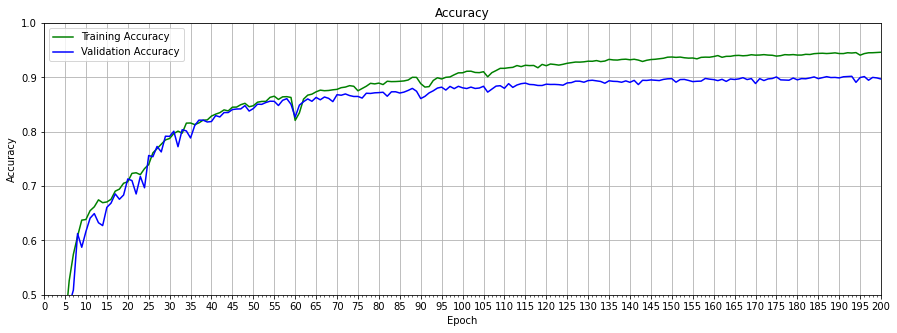

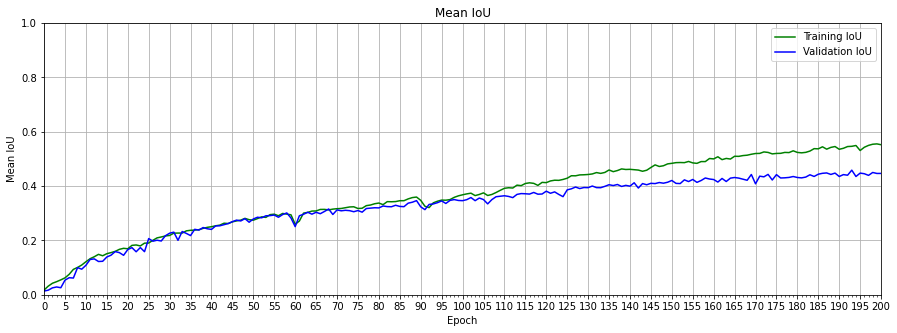

In [ ]:
# Pixel accuracy
train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]

# Mean IoU.
train_iou = history.history["mean_iou"]
valid_iou = history.history["val_mean_iou"]

plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.5, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

plot_results([ train_iou, valid_iou ], 
            ylabel="Mean IoU",
            ylim = [0.0, 1.0],
            metric_name=["Training IoU", "Validation IoU"],
            color=["g", "b"])

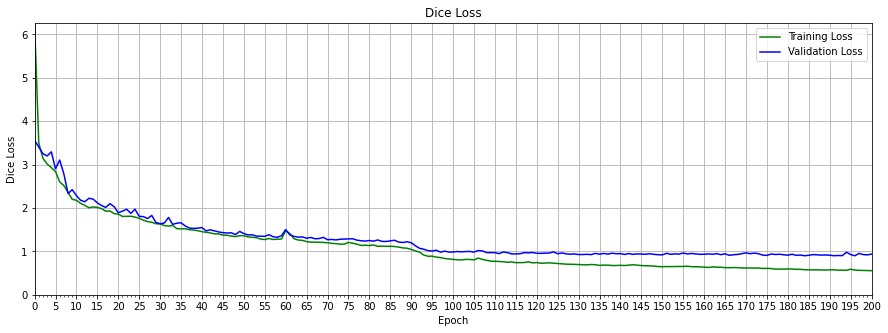

In [ ]:
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

max_loss = max(max(train_loss), max(valid_loss))

plot_results([ train_loss, valid_loss ],        
            ylabel='Dice Loss', 
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

##  Perform Inference 

In [ ]:
trained_model = tf.keras.models.load_model(version_dir, custom_objects={'mean_iou':mean_iou,
                                                                        'dice_coef_loss':dice_coef_loss})

In [ ]:
evaluate = trained_model.evaluate(valid_ds)

print(f"Model evaluation accuracy:   {evaluate[1]*100.:.3f}")
print(f"Model evaluation IoU:        {evaluate[2]*100.:.3f}")

12/12 [==============================] - 10s 804ms/step - loss: 0.9026 - accuracy: 0.9020 - mean_iou: 0.4585
Model evaluation accuracy:   90.196
Model evaluation IoU:        45.853


### Inference using Dataset Objects

In [ ]:
def inference(model, dataset):

    num_batches_to_process = InferenceConfig.NUM_BATCHES

    for idx, data in enumerate(dataset):
        
        batch_img, batch_mask = data[0], data[1]
        pred_all = (model.predict(batch_img)).astype('float32')
        pred_all = pred_all.argmax(-1)
        batch_img = (batch_img).astype('uint8')
        if idx == num_batches_to_process:
            break

        for i in range(0, len(batch_img)):
            
            fig = plt.figure(figsize=(20,8))
            
            # Display the original image.
            ax1 = fig.add_subplot(1,4,1)
            ax1.imshow(batch_img[i])
            ax1.title.set_text('Actual frame')
            plt.axis('off')
            
            # Display the ground truth mask.
            true_mask_rgb = num_to_rgb(batch_mask[i], color_map=id2color)
            ax2 = fig.add_subplot(1,4,2)
            ax2.set_title('Ground truth labels')
            ax2.imshow(true_mask_rgb)
            plt.axis('off')
            
            # Display the predicted segmentation mask. 
            pred_mask_rgb = num_to_rgb(pred_all[i], color_map=id2color)
            ax3 = fig.add_subplot(1,4,3)
            ax3.set_title('Predicted labels')
            ax3.imshow(pred_mask_rgb)
            plt.axis('off')

            # Display the predicted segmentation mask overlayed on the original image.
            overlayed_image = image_overlay(batch_img[i], pred_mask_rgb)
            ax4 = fig.add_subplot(1,4,4)
            ax4.set_title('Overlayed image')
            ax4.imshow(overlayed_image)
            plt.axis('off')
            
            plt.show()

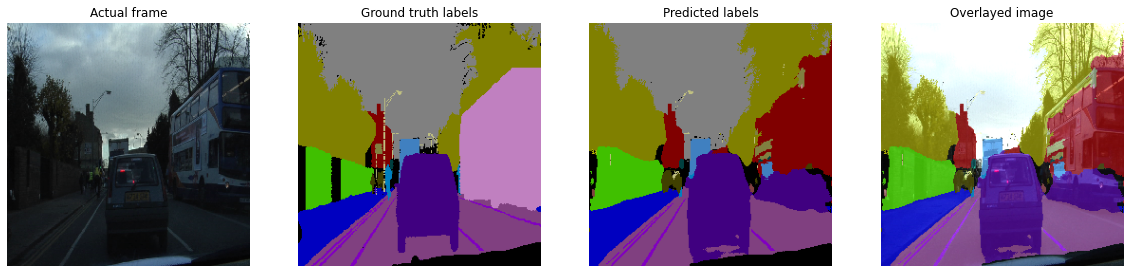

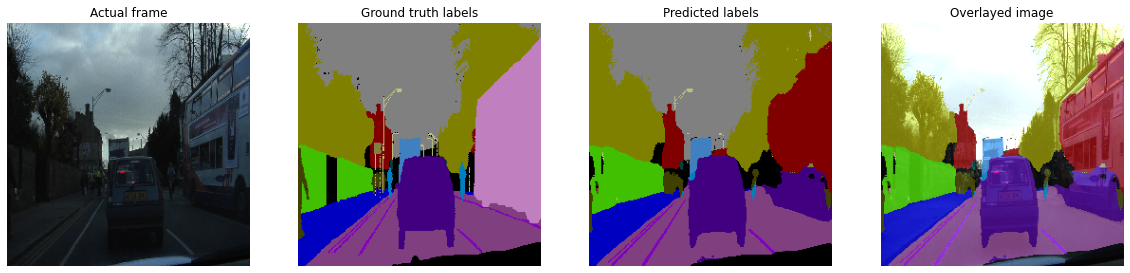

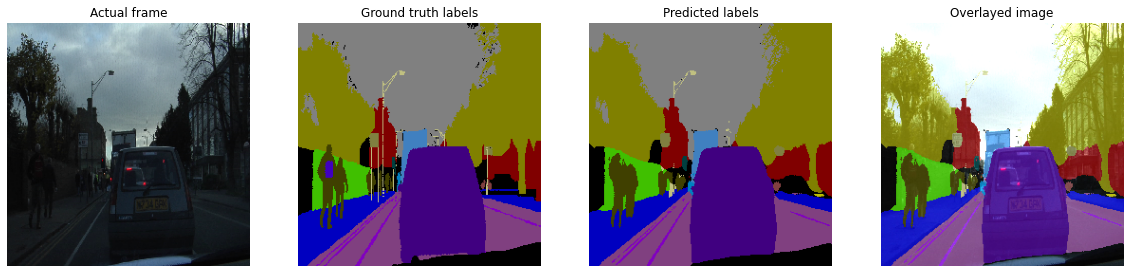

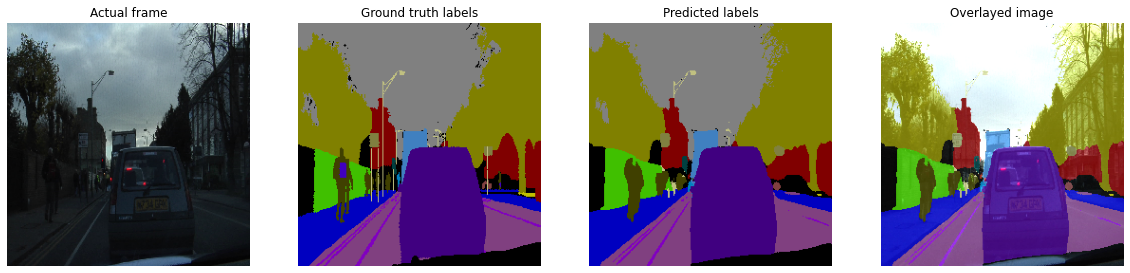

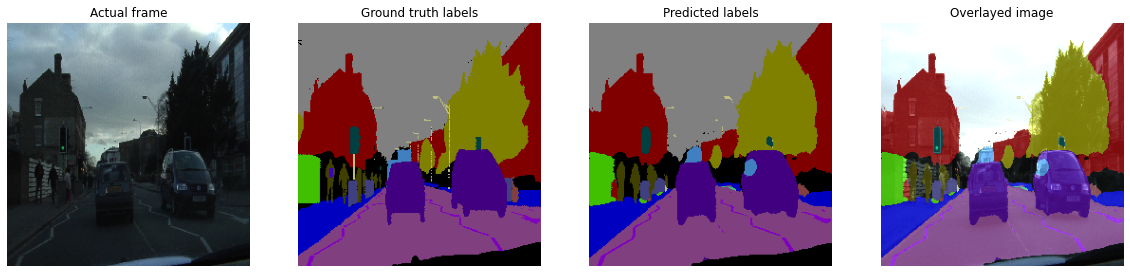

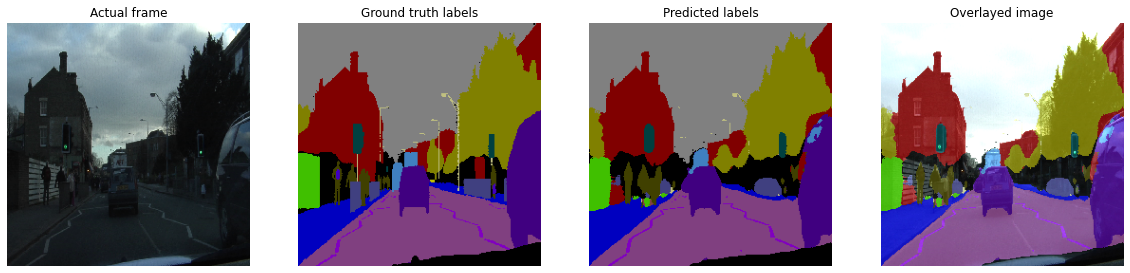

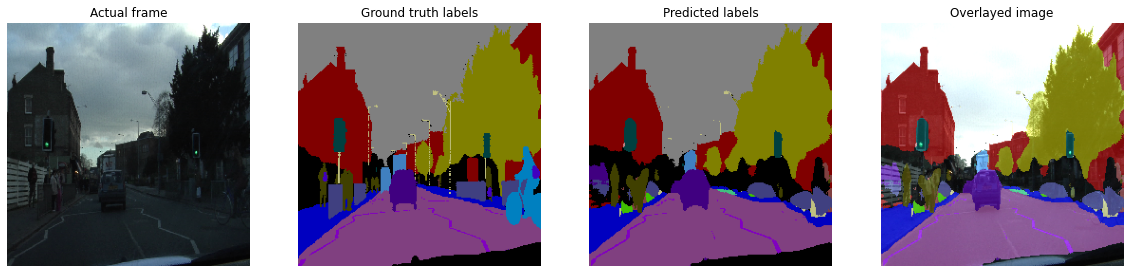

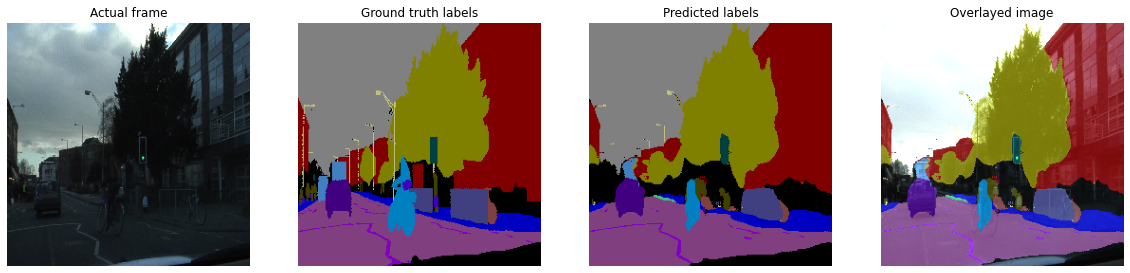

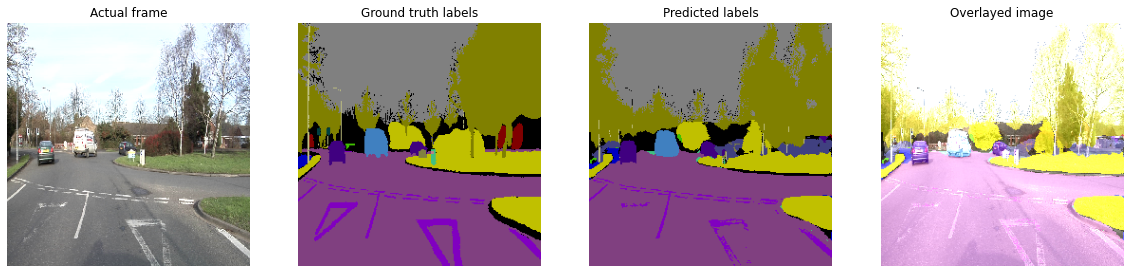

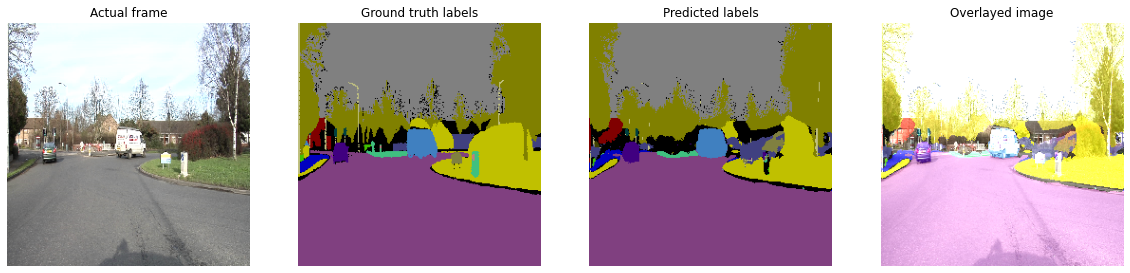

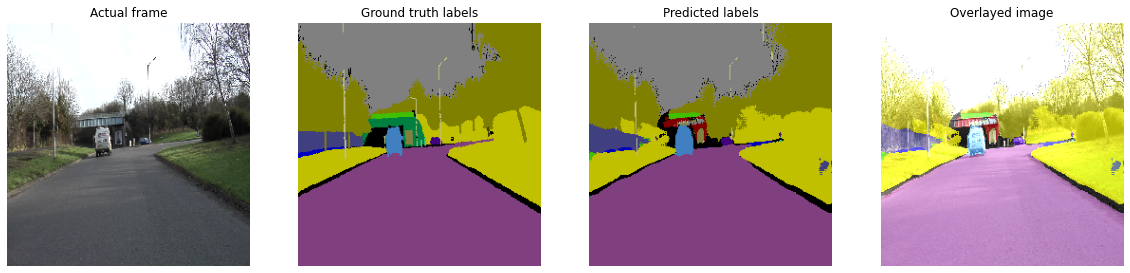

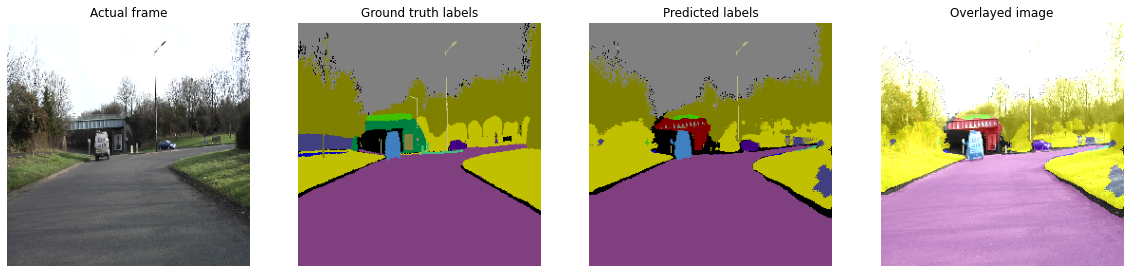

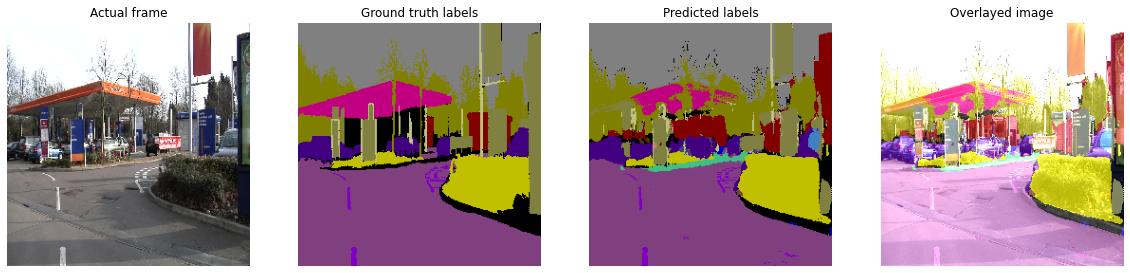

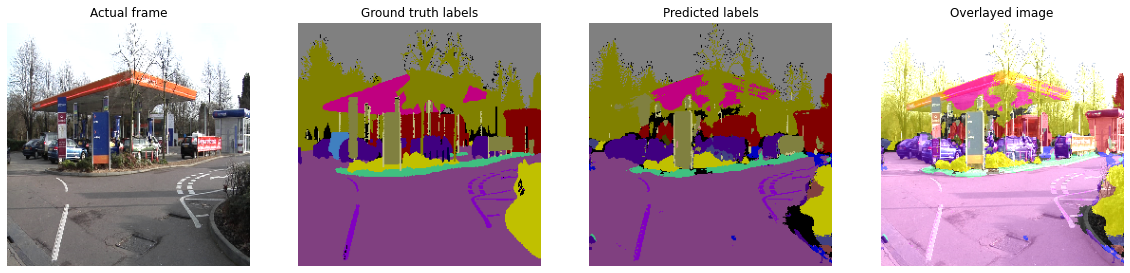

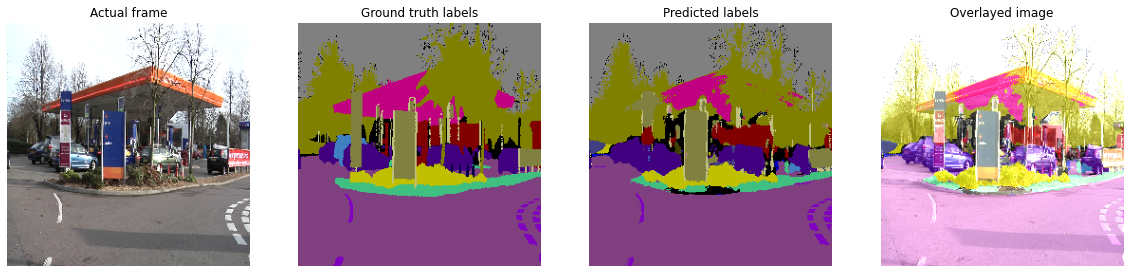

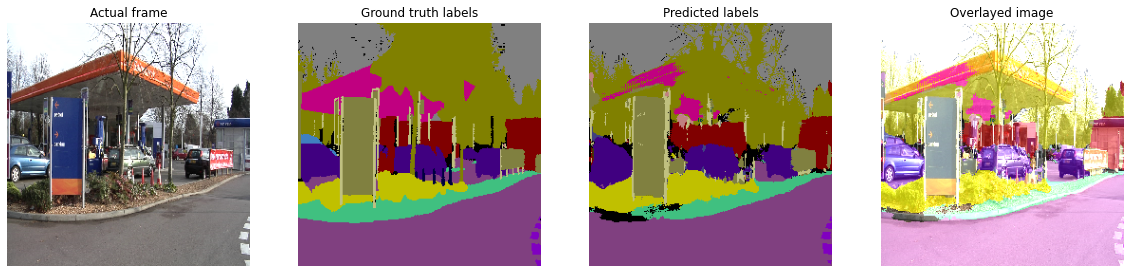

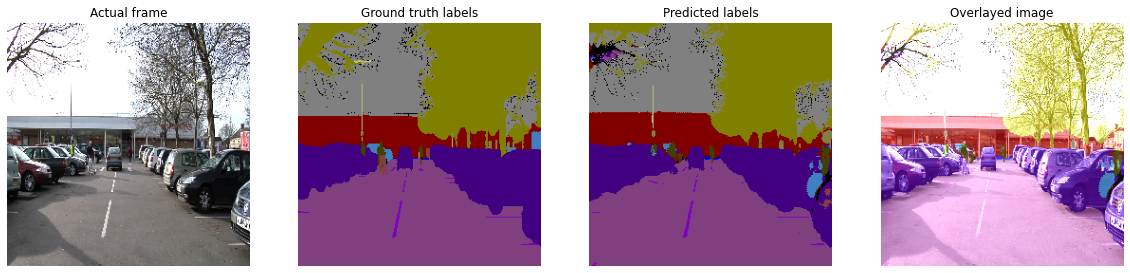

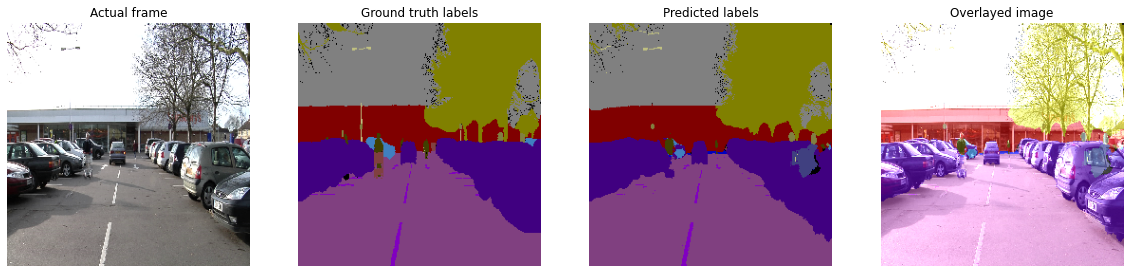

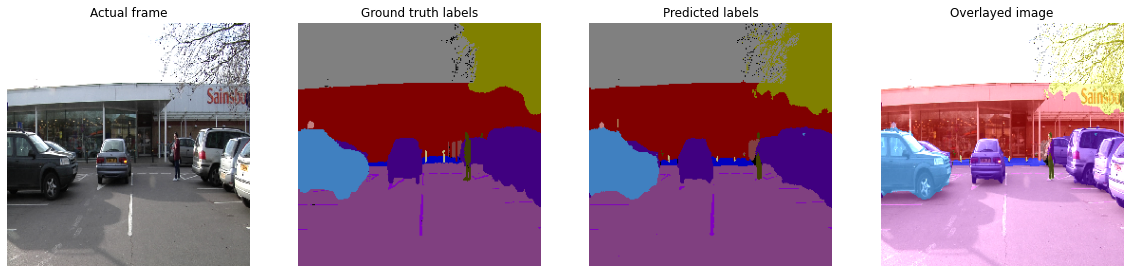

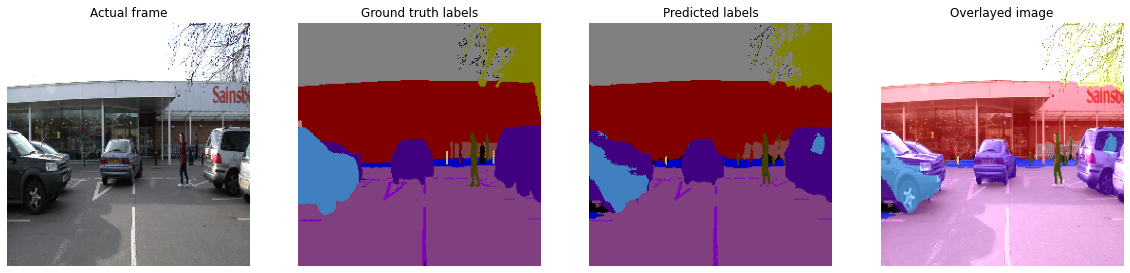

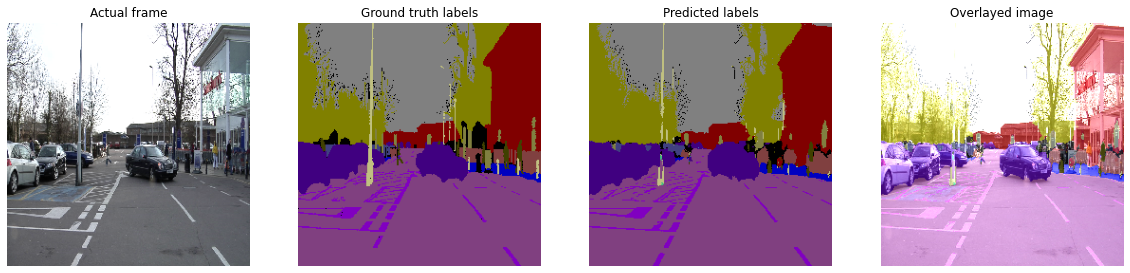

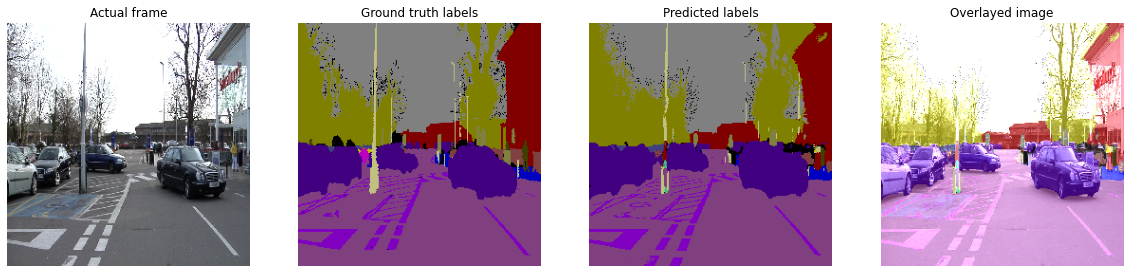

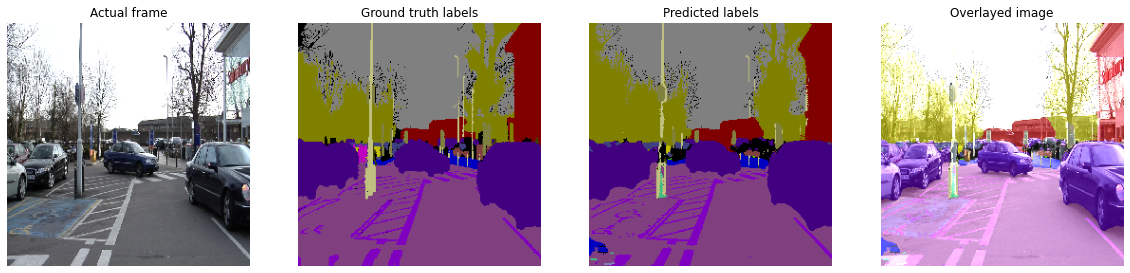

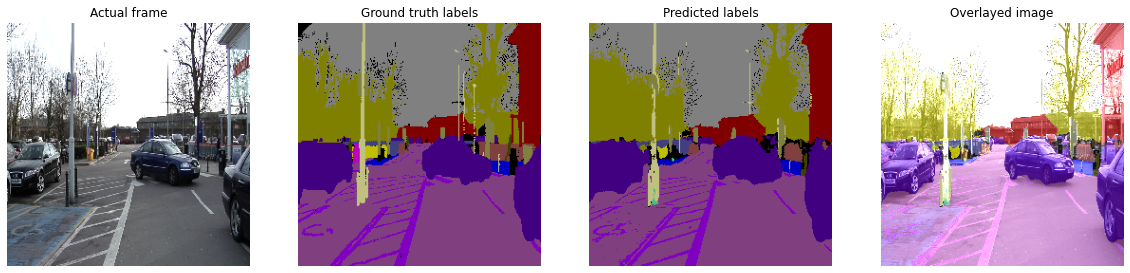

In [ ]:
_, valid_ds = create_datasets()

inference(trained_model, valid_ds)